In [1]:
import matplotlib.pyplot as plt
from scipy.io import readsav
import numpy as np
import copy
from helita.io import lp
from astropy.io import fits
import sunpy.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops

In [2]:
dpath = '/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/'
dpath_area = '/mn/stornext/d9/souvikb/K_means_results/savefiles/'
dpath_cluster_fits= '/mn/stornext/d9/souvikb/K_means_results/'
dpath_timesteps ='/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/calib_tseries/'
dpath_npz = '/mn/stornext/d9/souvikb/K_means_results/'

In [3]:
cluster_mask = fits.getdata(dpath_cluster_fits+'clusters_mask.fits',ext=0)# Reading the Cluster mask time series
hdrH_im =lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
hdrH_sp = lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])
time_sst = readsav(dpath_timesteps+'tseries_3950_2017-05-25T09:12:00_scans=0-424_calib.sav')
time_sst=time_sst['time']
hdr_Mag = lp.getheader(dpath+'Blos_6302_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
dim_Mag = hdr_Mag[0]
cube_Mag = lp.getdata(dpath+'Blos_6302_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cube_Mag = np.reshape(cube_Mag,[dim_Mag[0],dim_Mag[1],dim_Mag[2]])
cube_Mag=np.swapaxes(cube_Mag,0,1)
h_alpha=np.swapaxes(cubeH,0,1)

In [4]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap
#mycmap = transparent_cmap(plt.cm.jet)

In [5]:
mean_abs_mag=np.mean(np.abs(cube_Mag),axis=2)

# Without temporal filtering

## Blue excursions 

In [6]:
#Labelling the clusters in 3D by considering all the structures. 
cluster_interest_blue = [12,48,49,25,11,5] # considering the shadows as well. 
master_aux_cube_blue=cluster_mask*0
for clust_index in range(len(cluster_interest_blue)):
    master_aux_cube_blue[np.where(cluster_mask == cluster_interest_blue[clust_index])] = 1.

In [7]:
#labelling the 3d cube
labeled_3d = label(master_aux_cube_blue,return_num=True, connectivity=2)

In [53]:
# Now creating a bw hit mask based on RPs so that you
# can have an identification which segment of the 3D label 
# belongs to which velocity compartment
cluster_interest_blue_fast=[12,48] #Check COG.ipynb for this 
master_aux_cube_blue_fast=cluster_mask*0
for clust_index in range(len(cluster_interest_blue_fast)):
    master_aux_cube_blue_fast[np.where(cluster_mask == cluster_interest_blue_fast[clust_index])] = 1.

In [63]:
cluster_interest_blue_inter=[49,25] #Check COG.ipynb for this 
master_aux_cube_blue_inter=cluster_mask*0
for clust_index in range(len(cluster_interest_blue_inter)):
    master_aux_cube_blue_inter[np.where(cluster_mask == cluster_interest_blue_inter[clust_index])] = 1.

In [64]:
cluster_interest_blue_slow=[11,5] #Check COG.ipynb for this 
master_aux_cube_blue_slow=cluster_mask*0
for clust_index in range(len(cluster_interest_blue_slow)):
    master_aux_cube_blue_slow[np.where(cluster_mask == cluster_interest_blue_slow[clust_index])] = 1.

In [65]:
label_3d_blue_fast =master_aux_cube_blue_fast*0.
label_3d_blue_inter =master_aux_cube_blue_fast*0.
label_3d_blue_slow =master_aux_cube_blue_fast*0.
for scan in range(425):
    label_3d_blue_fast[:,:,scan]=master_aux_cube_blue_fast[:,:,scan]*labeled_3d[0][:,:,scan]
    label_3d_blue_inter[:,:,scan]=master_aux_cube_blue_inter[:,:,scan]*labeled_3d[0][:,:,scan]
    label_3d_blue_slow[:,:,scan]=master_aux_cube_blue_slow[:,:,scan]*labeled_3d[0][:,:,scan]

In [13]:
size = label_3d_blue_fast.shape

In [55]:
# Without temporal filtering: without putting a threshold of 140 s as I had done before. 
number_blue_fast = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_fast[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_fast[row,col,:])
            number_blue_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_fast[row,col] = 0.          

In [66]:
number_blue_inter = np.zeros((size[0],size[1]))
number_blue_slow = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_inter[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_inter[row,col,:])
            number_blue_inter[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_inter[row,col] = 0.          

In [67]:
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_slow[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_slow[row,col,:])
            number_blue_slow[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_slow[row,col] = 0.          

## Red Excursions 

In [78]:
#Labelling the clusters in 3D by considering all the structures. 
cluster_interest_red = [18,46,26,36,8,16] # considering the shadows as well. 
master_aux_cube_red=cluster_mask*0
for clust_index in range(len(cluster_interest_red)):
    master_aux_cube_red[np.where(cluster_mask == cluster_interest_red[clust_index])] = 1.

In [79]:
#labelling the 3d cube
labeled_3d_red = label(master_aux_cube_red,return_num=True, connectivity=2)

In [80]:
# Now creating a bw hit mask based on RPs so that you
# can have an identification which segment of the 3D label 
# belongs to which velocity compartment
cluster_interest_red_fast=[18,46] #Check COG.ipynb for this 
master_aux_cube_red_fast=cluster_mask*0
for clust_index in range(len(cluster_interest_red_fast)):
    master_aux_cube_red_fast[np.where(cluster_mask == cluster_interest_red_fast[clust_index])] = 1.

In [81]:
cluster_interest_red_inter=[26,36] #Check COG.ipynb for this 
master_aux_cube_red_inter=cluster_mask*0
for clust_index in range(len(cluster_interest_red_inter)):
    master_aux_cube_red_inter[np.where(cluster_mask == cluster_interest_red_inter[clust_index])] = 1.

In [82]:
cluster_interest_red_slow=[8,16] #Check COG.ipynb for this 
master_aux_cube_red_slow=cluster_mask*0
for clust_index in range(len(cluster_interest_red_slow)):
    master_aux_cube_red_slow[np.where(cluster_mask == cluster_interest_red_slow[clust_index])] = 1.

In [83]:
label_3d_red_fast =master_aux_cube_red_fast*0.
label_3d_red_inter =master_aux_cube_red_fast*0.
label_3d_red_slow =master_aux_cube_red_fast*0.
for scan in range(425):
    label_3d_red_fast[:,:,scan]=master_aux_cube_red_fast[:,:,scan]*labeled_3d_red[0][:,:,scan]
    label_3d_red_inter[:,:,scan]=master_aux_cube_red_inter[:,:,scan]*labeled_3d_red[0][:,:,scan]
    label_3d_red_slow[:,:,scan]=master_aux_cube_red_slow[:,:,scan]*labeled_3d_red[0][:,:,scan]

In [84]:
# Without temporal filtering: without putting a threshold of 140 s as I had done before. 
number_red_fast = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_red_fast[row,col,:].any()!=0:
            u = np.unique(label_3d_red_fast[row,col,:])
            number_red_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_red_fast[row,col] = 0.          

In [85]:
number_red_inter = np.zeros((size[0],size[1]))
number_red_slow = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_red_inter[row,col,:].any()!=0:
            u = np.unique(label_3d_red_inter[row,col,:])
            number_red_inter[row,col] = len(np.where(u!=0)[0])
        else :
            number_red_inter[row,col] = 0.          

In [86]:
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_red_slow[row,col,:].any()!=0:
            u = np.unique(label_3d_red_slow[row,col,:])
            number_red_slow[row,col] = len(np.where(u!=0)[0])
        else :
            number_red_slow[row,col] = 0.          

## Complete plotting routine

Locator attempting to generate 1168 ticks ([0.0, ..., 7.002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1201 ticks ([0.0, ..., 12.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([0.0, ..., 20.0]), which exceeds Locator.MAXTICKS (1000).


Text(3.5, 55, '(f)')

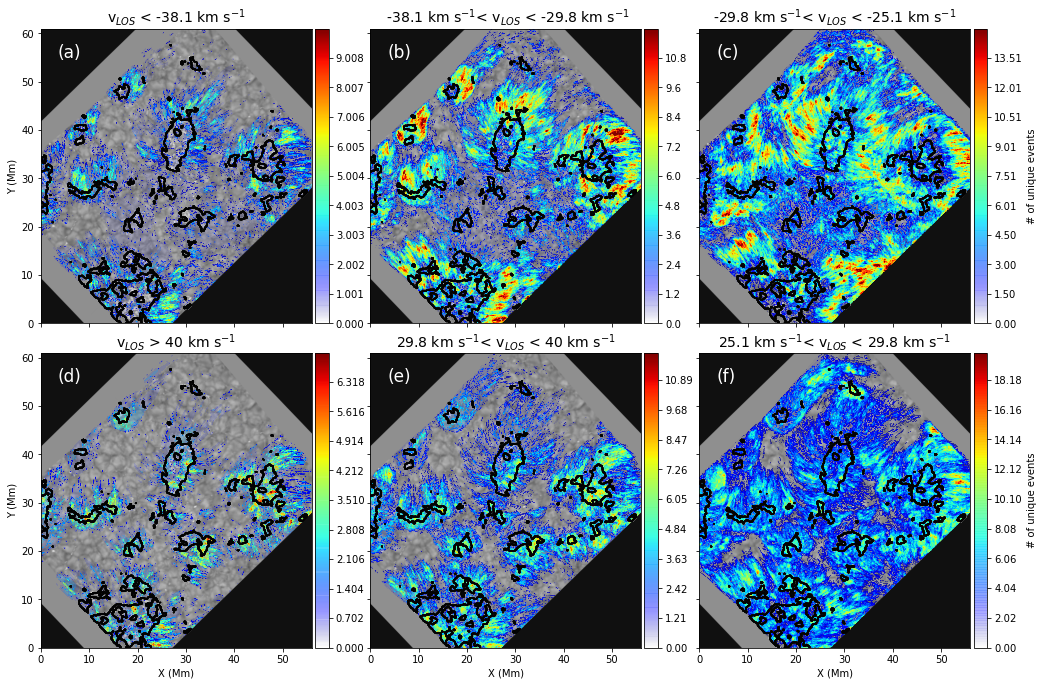

In [87]:
mycmap = transparent_cmap(plt.cm.jet)
mask = mean_abs_mag*0
mask[np.where(mean_abs_mag>=100)]=1.

fig, axs =plt.subplots(2,3,figsize=(15,10),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1,wspace=0.05,left=0.05,right=0.95,top=0.93,bottom=0.07)
axs=axs.ravel()
axs[0].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[0].contourf(number_blue_fast/1.,origin='lower',cmap=mycmap,levels=np.linspace(0,10,1200),extent=[0,56,0,61])
im1=axs[0].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[0])
cax0 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax0)
plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[0].get_yticklabels(), visible=False)
axs[0].set_title(r'v$_{LOS}$ < -38.1 km s$^{-1}$',fontsize=14)
axs[0].set_ylabel('Y (Mm)')
axs[0].text(3.5,55,'(a)',color='white',fontsize=17)

axs[1].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[1].contourf(number_blue_inter/1,origin='lower',cmap=mycmap,levels=np.linspace(0,12,1200),extent=[0,56,0,61])
im1=axs[1].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax1)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[1].set_title(r' -38.1 km s$^{-1}$< v$_{LOS}$ < -29.8 km s$^{-1}$',fontsize=14)
axs[1].text(3.5,55,'(b)',color='white',fontsize=17)

axs[2].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[2].contourf(number_blue_slow,origin='lower',cmap=mycmap,levels=np.linspace(0,15,1200),extent=[0,56,0,61])
im1=axs[2].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[2].get_xticklabels(), visible=False)
plt.setp(axs[2].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[2])
cax2 = divider1.append_axes("right", size="5%", pad=0.05)
cbar2=plt.colorbar(im,cax=cax2)
cbar2.set_label('# of unique events')
axs[2].set_title(r'-29.8 km s$^{-1}$< v$_{LOS}$ < -25.1 km s$^{-1}$',fontsize=14)
axs[2].text(3.5,55,'(c)',color='white',fontsize=17)

axs[3].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[3].contourf(number_red_fast,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[3].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[3])
cax3 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax3)
axs[3].set_title(r'v$_{LOS}$ > 40 km s$^{-1}$',fontsize=14)
axs[3].set_ylabel('Y (Mm)')
axs[3].set_xlabel('X (Mm)')
axs[3].text(3.5,55,'(d)',color='white',fontsize=17)
#axs[3].text(36,4,r'N$_{tot}$ = '+format(label_red_fast[1]),color='white',fontsize=13)

axs[4].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[4].contourf(number_red_inter,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[4].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[4].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[4])
cax4 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax4)
axs[4].set_xlabel('X (Mm)')
axs[4].set_title(r'29.8 km s$^{-1}$< v$_{LOS}$ < 40 km s$^{-1}$',fontsize=14)
axs[4].text(3.5,55,'(e)',color='white',fontsize=17)
#axs[4].text(36,4,r'N$_{tot}$ = '+format(label_red_inter[1]),color='white',fontsize=13)

axs[5].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[5].contourf(number_red_slow,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[5].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[5].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[5])
cax5 = divider1.append_axes("right", size="5%", pad=0.05)
cbar5=plt.colorbar(im,cax=cax5)
cbar5.set_label('# of unique events')
axs[5].set_title(r'25.1 km s$^{-1}$< v$_{LOS}$ < 29.8 km s$^{-1}$',fontsize=14)
axs[5].set_xlabel('X (Mm)')
axs[5].text(3.5,55,'(f)',color='white',fontsize=17)
#axs[5].text(36,4,r'N$_{tot}$ = '+format(label_red_slow[1]),color='white',fontsize=13)
#plt.subplot_adjust()
#plt.savefig('/mn/stornext/u3/souvikb/paper4_images/2d_events_spicules_v2.png')

# Second version with lifetime filtering 
**It is important to note that lifetime filtering was applied while producing the lifetime map**

In [69]:
data1 = np.load(dpath_npz+'lifetime_blu_fast.npz',allow_pickle=True)
new_data1 = data1['arr_0']
ww_list = list(new_data1)#converting into list for ease of operation
lifetime_blue_fast = [k[0] for k in ww_list]
label_blue_fast = [k[1] for k in ww_list]
lifetime_blue_fast = np.array(lifetime_blue_fast)
label_blue_fast = np.array(label_blue_fast)

In [70]:
data2 = np.load(dpath_npz+'lifetime_blu_inter.npz',allow_pickle=True)
new_data2 = data2['arr_0']
ww_list = list(new_data2)#converting into list for ease of operation
lifetime_blue_inter = [k[0] for k in ww_list]
label_blue_inter = [k[1] for k in ww_list]
lifetime_blue_inter = np.array(lifetime_blue_inter)
label_blue_inter = np.array(label_blue_inter)

In [71]:
data3 = np.load(dpath_npz+'lifetime_blu_slow.npz',allow_pickle=True)
new_data3 = data3['arr_0']
ww_list = list(new_data3)#converting into list for ease of operation
lifetime_blue_slow = [k[0] for k in ww_list]
label_blue_slow = [k[1] for k in ww_list]
lifetime_blue_slow = np.array(lifetime_blue_slow)
label_blue_slow = np.array(label_blue_slow)

In [72]:
w1 = np.where(lifetime_blue_fast >=140.)
w2 = np.where(lifetime_blue_inter >=140.)
w3 = np.where(lifetime_blue_slow >=140.)

In [73]:
# Creating the number density maps. Each of these maps will give a representation of the number of detected RBEs
number_blue_fast_life = np.zeros((size[0],size[1]))
number_blue_inter_life = np.zeros((size[0],size[1]))
number_blue_slow_life = np.zeros((size[0],size[1]))

for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_fast[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_fast[row,col,:])
            u_imp = np.where(np.isin(u,label_blue_fast[w1[0]]) == False) # brings out the indices whereever it is FALSE.
            number_blue_fast_life[row,col] = len(np.where(u[u_imp]!=0)[0])
            #number_blue_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_fast_life[row,col] = 0.          

In [74]:
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_inter[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_inter[row,col,:])
            u_imp = np.where(np.isin(u,label_blue_inter[w2[0]]) == False) # brings out the indices whereever it is FALSE.
            number_blue_inter_life[row,col] = len(np.where(u[u_imp]!=0)[0])
            #number_blue_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_inter_life[row,col] = 0.          

In [75]:
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_slow[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_slow[row,col,:])
            u_imp = np.where(np.isin(u,label_blue_slow[w3[0]]) == False) # brings out the indices whereever it is FALSE.
            number_blue_slow_life[row,col] = len(np.where(u[u_imp]!=0)[0])
            #number_blue_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_slow_life[row,col] = 0.          

## Red excursions

In [88]:
data4 = np.load(dpath_npz+'lifetime_red_fast.npz',allow_pickle=True)
new_data4 = data4['arr_0']
ww_list = list(new_data4)#converting into list for ease of operation
lifetime_rd_fast = [k[0] for k in ww_list]
label_rd_fast = [k[1] for k in ww_list]
lifetime_rd_fast = np.array(lifetime_rd_fast)
label_rd_fast = np.array(label_rd_fast)

In [89]:
data5 = np.load(dpath_npz+'lifetime_red_inter.npz',allow_pickle=True)
new_data5 = data5['arr_0']
ww_list = list(new_data5)#converting into list for ease of operation
lifetime_rd_inter = [k[0] for k in ww_list]
label_rd_inter = [k[1] for k in ww_list]
lifetime_rd_inter = np.array(lifetime_rd_inter)
label_rd_inter = np.array(label_rd_inter)

In [90]:
data6 = np.load(dpath_npz+'lifetime_red_slow.npz',allow_pickle=True)
new_data6 = data6['arr_0']
ww_list = list(new_data6)#converting into list for ease of operation
lifetime_rd_slow = [k[0] for k in ww_list]
label_rd_slow = [k[1] for k in ww_list]
lifetime_rd_slow = np.array(lifetime_rd_slow)
label_rd_slow = np.array(label_rd_slow)

In [91]:
w4 = np.where(lifetime_rd_fast >=140.)
w5 = np.where(lifetime_rd_inter >=140.)
w6 = np.where(lifetime_rd_slow >=140.)

In [94]:
# Creating the number density maps. Each of these maps will give a representation of the number of detected RREs
number_red_fast_life = np.zeros((size[0],size[1]))
number_red_inter_life = np.zeros((size[0],size[1]))
number_red_slow_life = np.zeros((size[0],size[1]))

for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_red_fast[row,col,:].any()!=0:
            u = np.unique(label_3d_red_fast[row,col,:])
            u_imp = np.where(np.isin(u,label_rd_fast[w4[0]]) == False) # brings out the indices whereever it is FALSE.
            number_red_fast_life[row,col] = len(np.where(u[u_imp]!=0)[0])
        else :
            number_red_fast_life[row,col] = 0.
            
        if label_3d_red_inter[row,col,:].any()!=0:
            u = np.unique(label_3d_red_inter[row,col,:])
            u_imp = np.where(np.isin(u,label_rd_inter[w5[0]]) == False) # brings out the indices whereever it is FALSE.
            number_red_inter_life[row,col] = len(np.where(u[u_imp]!=0)[0])
        else:
            number_red_inter_life[row,col]=0.
        
        if label_3d_red_slow[row,col,:].any()!=0:
            u = np.unique(label_3d_red_slow[row,col,:])
            u_imp = np.where(np.isin(u,label_rd_slow[w6[0]]) == False) # brings out the indices whereever it is FALSE.
            number_red_slow_life[row,col] = len(np.where(u[u_imp]!=0)[0])
        else:
            number_red_slow_life[row,col]=0.

Locator attempting to generate 1168 ticks ([0.0, ..., 7.002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1201 ticks ([0.0, ..., 12.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([0.0, ..., 20.0]), which exceeds Locator.MAXTICKS (1000).


Text(3.5, 55, '(f)')

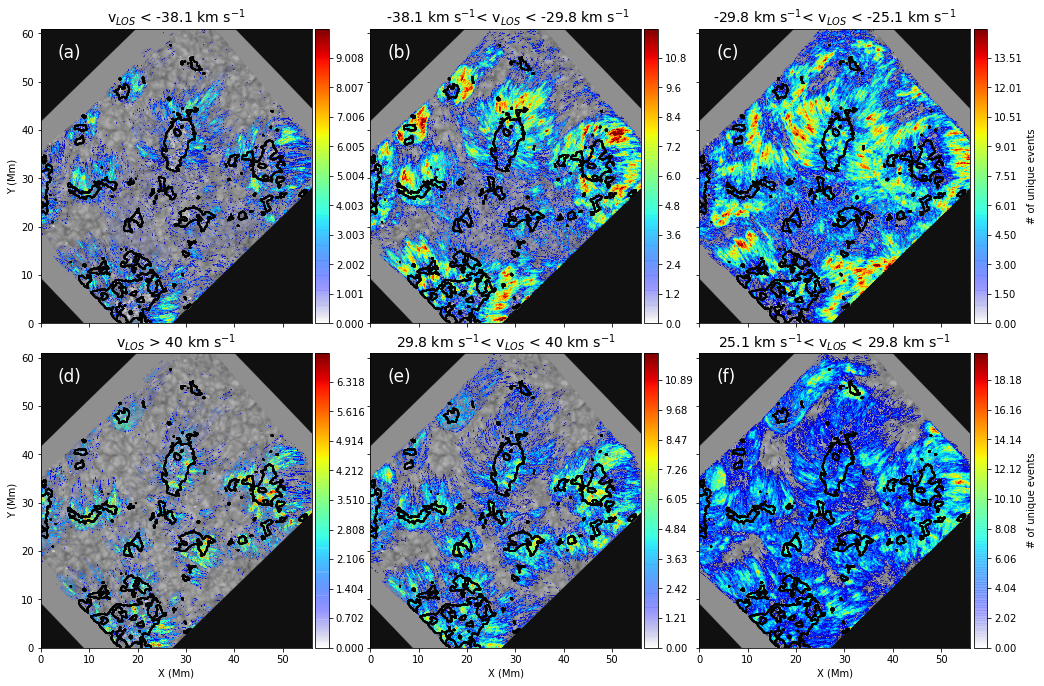

In [96]:
fig, axs =plt.subplots(2,3,figsize=(15,10),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1,wspace=0.05,left=0.05,right=0.95,top=0.93,bottom=0.07)
axs=axs.ravel()
axs[0].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[0].contourf(number_blue_fast_life/1.,origin='lower',cmap=mycmap,levels=np.linspace(0,10,1200),extent=[0,56,0,61])
im1=axs[0].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[0])
cax0 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax0)
plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[0].get_yticklabels(), visible=False)
axs[0].set_title(r'v$_{LOS}$ < -38.1 km s$^{-1}$',fontsize=14)
axs[0].set_ylabel('Y (Mm)')
axs[0].text(3.5,55,'(a)',color='white',fontsize=17)

axs[1].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[1].contourf(number_blue_inter_life/1,origin='lower',cmap=mycmap,levels=np.linspace(0,12,1200),extent=[0,56,0,61])
im1=axs[1].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax1)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[1].set_title(r' -38.1 km s$^{-1}$< v$_{LOS}$ < -29.8 km s$^{-1}$',fontsize=14)
axs[1].text(3.5,55,'(b)',color='white',fontsize=17)

axs[2].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[2].contourf(number_blue_slow_life,origin='lower',cmap=mycmap,levels=np.linspace(0,15,1200),extent=[0,56,0,61])
im1=axs[2].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[2].get_xticklabels(), visible=False)
plt.setp(axs[2].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[2])
cax2 = divider1.append_axes("right", size="5%", pad=0.05)
cbar2=plt.colorbar(im,cax=cax2)
cbar2.set_label('# of unique events')
axs[2].set_title(r'-29.8 km s$^{-1}$< v$_{LOS}$ < -25.1 km s$^{-1}$',fontsize=14)
axs[2].text(3.5,55,'(c)',color='white',fontsize=17)

axs[3].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[3].contourf(number_red_fast_life,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[3].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[3])
cax3 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax3)
axs[3].set_title(r'v$_{LOS}$ > 40 km s$^{-1}$',fontsize=14)
axs[3].set_ylabel('Y (Mm)')
axs[3].set_xlabel('X (Mm)')
axs[3].text(3.5,55,'(d)',color='white',fontsize=17)
#axs[3].text(36,4,r'N$_{tot}$ = '+format(label_red_fast[1]),color='white',fontsize=13)

axs[4].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[4].contourf(number_red_inter_life,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[4].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[4].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[4])
cax4 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax4)
axs[4].set_xlabel('X (Mm)')
axs[4].set_title(r'29.8 km s$^{-1}$< v$_{LOS}$ < 40 km s$^{-1}$',fontsize=14)
axs[4].text(3.5,55,'(e)',color='white',fontsize=17)
#axs[4].text(36,4,r'N$_{tot}$ = '+format(label_red_inter[1]),color='white',fontsize=13)

axs[5].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[5].contourf(number_red_slow_life,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[5].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[5].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[5])
cax5 = divider1.append_axes("right", size="5%", pad=0.05)
cbar5=plt.colorbar(im,cax=cax5)
cbar5.set_label('# of unique events')
axs[5].set_title(r'25.1 km s$^{-1}$< v$_{LOS}$ < 29.8 km s$^{-1}$',fontsize=14)
axs[5].set_xlabel('X (Mm)')
axs[5].text(3.5,55,'(f)',color='white',fontsize=17)
#axs[5].text(36,4,r'N$_{tot}$ = '+format(label_red_slow[1]),color='white',fontsize=13)
#plt.subplot_adjust()
#plt.savefig('/mn/stornext/u3/souvikb/paper4_images/2d_events_spicules_v2.png')